In [26]:
# worldcam correction testing
# pulled from analyze_ephys.py
# TO DO: organize into a usable function at some point

In [27]:
cd C:\src\GitHub\FreelyMovingEphys


C:\src\GitHub\FreelyMovingEphys


In [28]:
from util.splines import build_spline_matrix

In [29]:
cd \\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\fm1

\\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\012821\EE8P6LT\fm1


In [30]:
#cd \\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\021621\EE11P1LT\fm1

In [31]:
#name_base = '021621_EE11P1LT_control_Rig2_fm1'
name_base = '012821_EE8P6LT_control_Rig2_fm1'
eye_file = name_base + '_Reye.nc'
world_file = name_base + '_world.nc'
ephys_file = name_base + '_ephys_merge.json'
imu_file = name_base + "_imu.nc"
speed_file = name_base + "_speed.nc"

#free_move = True; has_imu = True; has_mouse = False;
free_move= True; has_imu = True; has_mouse = False;
stim_type = 'wn'

In [32]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
import subprocess
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.ndimage import shift as imshift
from scipy import signal
from sklearn.cluster import KMeans
from matplotlib.backends.backend_pdf import PdfPages
import scipy.optimize as op

from util.splines import build_spline_matrix

import scipy.sparse as sparse
import scipy.linalg as linalg
import scipy.stats as stats

from pyglmnet import GLM, simulate_glm

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [33]:
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])
sz = world_vid_raw.shape
downsamp = 1
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data
world_vid_raw = None

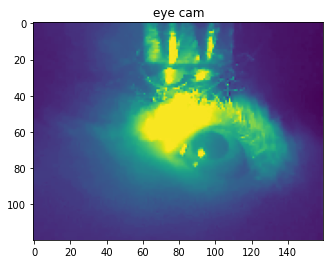

In [34]:
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
#omega = np.squeeze(np.array(eye_data['REYE_omega']))

In [35]:
print('opening ephys data')
ephys_data = pd.read_json(ephys_file)
ephys_data['spikeTraw'] = ephys_data['spikeT'].copy()

# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values

# get number of good units
n_units = len(goodcells)

opening ephys data


In [36]:
this_units = 0;
goodcells['spikeT'].iloc[0]


[0.6805333333,
 1.9886666667,
 2.0905666667,
 2.2627,
 2.7847,
 2.7998666667,
 2.8165,
 2.9331,
 3.1270666667,
 3.1438333333,
 3.2416333333,
 3.3884333333,
 3.491,
 3.5107333333,
 3.5658666667,
 3.6448333333000003,
 3.7044333333,
 3.8277333333,
 3.8471666667,
 3.8959,
 3.9384666667,
 3.9908,
 4.0501,
 4.1991666667,
 4.2449,
 4.2556,
 4.7156666667,
 4.8631333333,
 5.1908333333,
 5.5058,
 5.5675333333,
 5.598,
 5.6661666667,
 5.7003,
 5.8429333332999995,
 5.9119666667,
 6.0378,
 6.088,
 6.1027666667,
 6.2211,
 6.2964,
 6.3001000000000005,
 6.3290333333,
 6.3468333333,
 6.3492666667,
 6.3582666667,
 6.4147666667,
 6.4470333333,
 6.4615333333,
 6.4972666667,
 6.5481333333,
 6.5647,
 6.5847333333,
 6.5956666667,
 6.6403333333,
 6.7266,
 6.7701,
 6.9240333333,
 7.0898666667,
 7.1075666667,
 8.3768666667,
 8.3990666667,
 8.417033333300001,
 8.7775,
 8.8084,
 8.8854666667,
 8.9017666667,
 8.9089666667,
 8.9137333333,
 8.9259333333,
 8.9335,
 9.0534,
 9.135,
 9.5474666667,
 9.8960666667,
 9.979

In [37]:
acc_chans

<xarray.DataArray 'IMU_data' (channel: 1257636, sample: 6)>
[7545816 values with dtype=float64]
Coordinates:
  * channel     (channel) int64 0 100 200 300 ... 125763300 125763400 125763500
  * sample      (sample) object 'acc_x' 'acc_y' 'acc_z' ... 'gyro_y' 'gyro_z'
    timestamps  (channel) float64 ...

In [38]:
if free_move & has_imu:
    imu_data = xr.open_dataset(imu_file)
    acc_chans = imu_data.IMU_data
    try:
        gx = np.array(acc_chans.sel(channel='gyro_x'))
        gy = np.array(acc_chans.sel(channel='gyro_y'))
        gz = np.array(acc_chans.sel(channel='gyro_z'))
    except:
        gx = np.array(acc_chans.sel(sample='gyro_x'))
        gy = np.array(acc_chans.sel(sample='gyro_y'))
        gz = np.array(acc_chans.sel(sample='gyro_z'))

In [39]:
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
if free_move & has_imu:
    accTraw = imu_data.timestamps-ephysT0
if (free_move==False) & has_mouse:
    speedT = spd_tstamps-ephysT0
eyeT, worldT

(<xarray.DataArray 'timestamps' (frame: 251326)>
 array([-8.65951750e-01, -8.49836250e-01, -8.33797750e-01, ...,
         4.19247359e+03,  4.19248963e+03,  4.19250567e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 251321 251322 251323 251324 251325
     timestamps  (frame) float64 4.502e+04 4.502e+04 ... 4.921e+04 4.921e+04,
 <xarray.DataArray 'timestamps' (frame: 251329)>
 array([-9.05823750e-01, -8.88697250e-01, -8.72658750e-01, ...,
         4.19244124e+03,  4.19245773e+03,  4.19247377e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 251324 251325 251326 251327 251328
     timestamps  (frame) float64 4.502e+04 4.502e+04 ... 4.921e+04 4.921e+04)

In [40]:
# some video timestamps are out of order!!
order = np.argsort(np.array(worldT))
worldT = worldT[order].copy()
world_vid = world_vid[order,:,:].copy()

In [41]:
offset0 = 0.1;
drift_rate = -0.1/1000;
for i in ephys_data.index:
    ephys_data.at[i,'spikeT'] = np.array(ephys_data.at[i,'spikeTraw']) - (offset0 + np.array(ephys_data.at[i,'spikeTraw']) *drift_rate)
goodcells = ephys_data.loc[ephys_data['group']=='good']
if free_move & has_imu:
    accT= accTraw - (offset0 + accTraw*drift_rate)



In [56]:
def eye_shift_estimation(th,phi, eyeT, world_vid,worldT,max_frames):
    
    # get eye displacement for each worldcam frame
    th_interp = interp1d(eyeT,th,bounds_error = False)
    phi_interp = interp1d(eyeT, phi, bounds_error = False)
    dth = np.diff(th_interp(worldT))
    dphi = np.diff(phi_interp(worldT))
    
    # calculate x-y shift for each worldcam frame  
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_TRANSLATION
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
    warp_all = np.zeros((6,max_frames))
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        try: 
            (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
        except:
            cc[i] = np.nan;
            xshift[i]=np.nan; yshift[i] = np.nan;
            
    # performe regression to predict frameshift based on eye shifts
    
    #set up models; eyeData (th,phi) = predictors; shift (x,y) = outputs
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    
    # only use good data - not nans, good correlation between frames, small eye movements(not sacccades which are not compensatory)
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)
    
    # fit xshift 
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
    xmap = xmodel.coef_;
    xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
    print(xmap, xrscore)

    # fit yshift
    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])
    ymap = ymodel.coef_;
    yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])
    print(ymap,yrscore)
    
    return(xshift,yshift)

In [57]:
(xshift, yshift) = eye_shift_estimation(th,phi, eyeT, world_vid,worldT,max_frames)

100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [02:30<00:00, 23.95it/s]

[-1.2891      0.38324465] 0.5132999047823252
[0.48062793 1.03146419] 0.4968947436737291


TypeError: cannot unpack non-iterable NoneType object

Text(0, 0.5, 'phi')

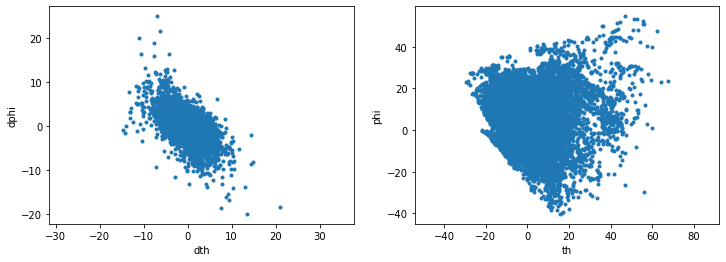

In [42]:
th_interp = interp1d(eyeT,th,bounds_error = False)
phi_interp = interp1d(eyeT, phi, bounds_error = False)
#omega_interp = interp1d(eyeT, omega, bounds_error = False)
dth = np.diff(th_interp(worldT))
dphi = np.diff(phi_interp(worldT))

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(dth[0:60*60*5],dphi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('dth')
plt.ylabel('dphi')

plt.subplot(1,2,2)
plt.plot(th[0:60*60*5],phi[0:60*60*5],'.')
plt.axis('equal')
plt.xlabel('th')
plt.ylabel('phi')

In [43]:
# get worldcam correction based on eye-movement vs frameshift regression
#calculate shift on each frame
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_TRANSLATION
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);
    warp_all = np.zeros((6,max_frames))
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        try: 
            (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
            xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
            warp_all[:,i] = np.reshape(warp_matrix,6)
        except:
            cc[i] = np.nan;
            xshift[i]=np.nan; yshift[i] = np.nan;
            warp_all[:,i] = np.nan

  1%|▌                                                                              | 26/3600 [00:00<00:15, 232.60it/s]

getting worldcam correction


100%|██████████████████████████████████████████████████████████████████████████████| 3600/3600 [02:24<00:00, 24.90it/s]


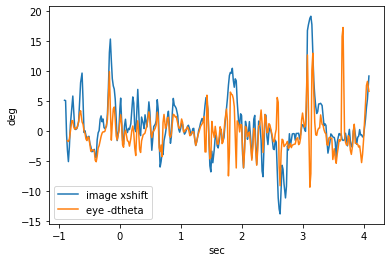

In [44]:
#plot a test trace (5secs)
maxt = 300
if free_move:
    plt.plot(worldT[0:maxt],xshift[0:maxt],label = 'image xshift')
    plt.plot(worldT[0:maxt],-dth[0:maxt]*1.5,label = 'eye -dtheta')
    #plt.xlim([100,300])
    plt.legend();
    plt.xlabel('sec'); plt.ylabel('deg')

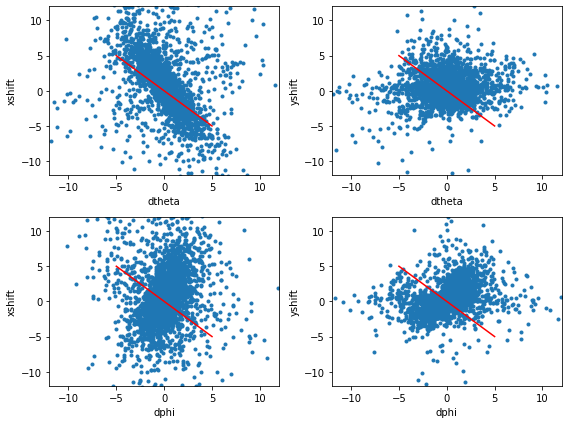

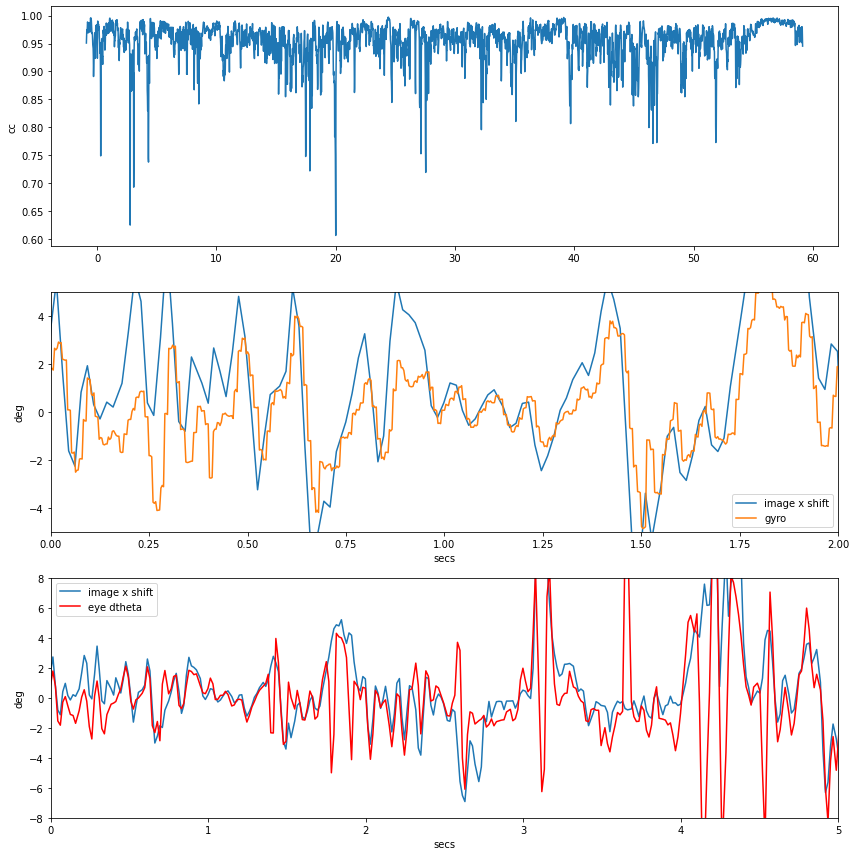

In [45]:
# a bunch of scatter plots
if free_move:
    plt.figure(figsize = (8,6))
    plt.subplot(2,2,1)
    plt.plot(dth[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('xshift')
    plt.subplot(2,2,2)
    plt.plot(dth[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dtheta'); plt.ylabel('yshift')
    plt.subplot(2,2,3)
    plt.plot(dphi[0:max_frames],xshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('xshift')
    plt.subplot(2,2,4)
    plt.plot(dphi[0:max_frames],yshift[0:max_frames],'.');plt.plot([-5, 5], [5, -5],'r'); plt.xlim(-12,12); plt.ylim(-12,12); plt.xlabel('dphi'); plt.ylabel('yshift')
    plt.tight_layout()

    plt.figure(figsize = (12,12))
    plt.subplot(3,1,1)
    plt.plot(worldT[0:max_frames],cc); plt.ylabel('cc')

    plt.subplot(3,1,2)
    plt.plot(worldT[0:max_frames],xshift, label = 'image x shift');
    plt.plot(accT,(gz-np.mean(gz))*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    #plt.plot(eyeT[0:-1],-dEye,label = 'eye dtheta')
    plt.xlim(0,2); plt.ylim(-5,5)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(worldT[0:max_frames],0.5*xshift, label = 'image x shift');
    #plt.plot(accT,-(gz-2.9)*7.5, label = 'gyro')
    #plt.plot(worldT[0:max_frames],yshift, label = 'y');
    plt.plot(worldT[0:-1],-dth,'r',label = 'eye dtheta', alpha = 1)
    plt.xlim(0,5); plt.ylim(-8,8)
    plt.xlabel('secs'); plt.ylabel('deg')
    plt.legend()
    plt.tight_layout()




In [46]:
# minimal fit regression
if free_move:
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)
    
    # fit xshift 
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
    xmap = xmodel.coef_;
    xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
    print(xmap, xrscore)

    # fit yshift
    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])
    ymap = ymodel.coef_;
    yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])
    print(ymap,yrscore)

else:
    xmap = [-1.33,  0.202]
    ymap =[0.431,  1.037]  # values for 012821 fm


[-1.2891      0.38324465] 0.5132999047823252
[0.48062793 1.03146419] 0.4968947436737291


[-1.2891      0.38324465] 0.5132999047823252
[0.48062793 1.03146419] 0.4968947436737291


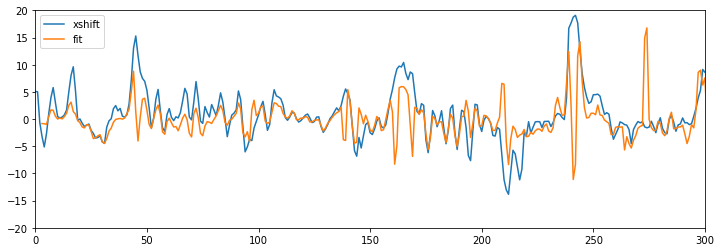

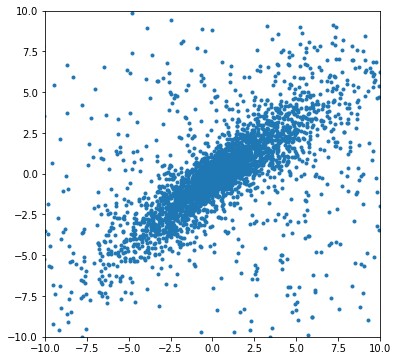

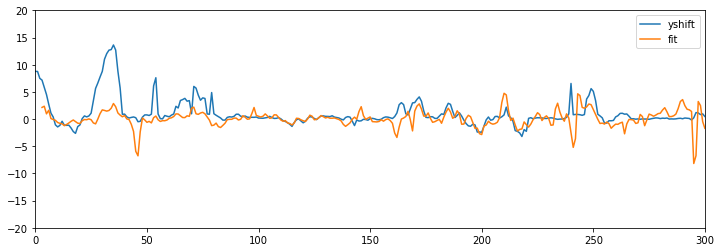

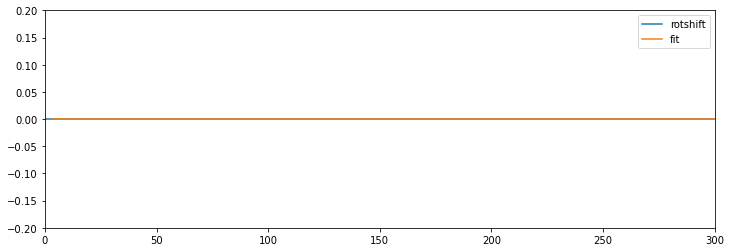

In [47]:
# fit regression
if free_move:
    xmodel = LinearRegression()
    ymodel = LinearRegression()
    rotmodel = LinearRegression()
    
    eyeData = np.zeros((max_frames,2))
    eyeData[:,0] = dth[0:max_frames];
    eyeData[:,1] = dphi[0:max_frames];
    
    rotshiftdata = warp_all[1,0:max_frames];
    xshiftdata = xshift[0:max_frames];
    yshiftdata = yshift[0:max_frames];
    
    usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)
    
    # fit xshift
    
    xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
    xmap = xmodel.coef_;
    xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
    print(xmap, xrscore)

    xfit = xmap[0]* dth + xmap[1]*dphi;
    plt.figure(figsize = (12,4))
    plt.plot(xshiftdata, label = 'xshift')
    plt.plot(xfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    plt.figure(figsize = (6,6))
    plt.plot(xshiftdata,xfit[0:len(xshiftdata)],'.'); plt.xlim(-10,10); plt.ylim(-10,10)

    # fit yshift
    ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])

    ymap = ymodel.coef_;
    yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])

    yfit = ymap[0] * dth + ymap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(yshiftdata, label = 'yshift')
    plt.plot(yfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-20,20)

    print(ymap,yrscore)
    
    # fit rotation shift
    rotmodel.fit(eyeData[usedata,:],rotshiftdata[usedata])

    rotmap = rotmodel.coef_;
    rotrscore = rotmodel.score(eyeData[usedata,:],rotshiftdata[usedata])

    rotfit = rotmap[0] * dth + rotmap[1]*dphi
    plt.figure(figsize = (12,4))
    plt.plot(rotshiftdata, label = 'rotshift')
    plt.plot(rotfit, label = 'fit'); plt.legend()
    plt.xlim(0,300); plt.ylim(-0.2,0.2)


    #print(rotmap,rotrscore)

else:
    xmap = [-1.33,  0.202]
    ymap =[0.431,  1.037]  # values for 012821 fm


In [48]:
print(xmap,ymap)

[-1.2891      0.38324465] [0.48062793 1.03146419]


In [49]:
# set up interpolators for eye and world videos
#eyeInterp = interp1d(eyeT,eye_vid,axis=0)
#worldInterp = interp1d(worldT,world_vid,axis=0)

In [50]:
if free_move & False:
    # eye correction movie
    eyeInterp = interp1d(eyeT,eye_vid,axis=0)
    worldInterp = interp1d(worldT,world_vid,axis=0)    
    print('getting eye correction movie')
    tr = [30,31]
    fig = plt.figure(figsize = (8,16))
    gs = fig.add_gridspec(10,1)
    axEye = fig.add_subplot(gs[0,0])
    axWorld = fig.add_subplot(gs[0:3,:])
    axWorldFix = fig.add_subplot(gs[3:6,:])

    axTheta = fig.add_subplot(gs[6,:])
    axPhi = fig.add_subplot(gs[7,:])
    axOmega = fig.add_subplot(gs[8,:])
    axGyro = fig.add_subplot(gs[9,:])

    th = np.array((eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
    phi = np.array((eye_params.sel(ellipse_params = 'phi')-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

    axTheta.plot(eyeT,th)
    axTheta.set_xlim(tr[0],tr[1]); 
    axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

    axPhi.plot(eyeT,phi)
    axPhi.set_xlim(tr[0],tr[1]); 
    axPhi.set_ylabel('phi - deg'); axPhi.set_ylim(-30,30)

    #axOmega.plot(eyeT,omega)
    axOmega.set_xlim(tr[0],tr[1]); 
    axOmega.set_ylabel('omega - deg'); axOmega.set_ylim(-20,20)

    if free_move & has_imu:
        axGyro.plot(accT,gz)
        axGyro.set_xlim(tr[0],tr[1]); 
        axGyro.set_ylabel('gyro - deg'); axGyro.set_ylim(2,4)

    thInterp =interp1d(eyeT,th)
    phiInterp =interp1d(eyeT,phi)
    pix_per_deg = 1.6

    vidfile = name_base +'_corrected.mp4'
    # now animate
    writer = FFMpegWriter(fps=30)
    with writer.saving(fig, vidfile, 100):
    #    for t in np.arange(tr[0],tr[1],1/30):
        for t in tqdm(worldT[(worldT>tr[0]) & (worldT<tr[1])]):        
            # show eye and world frames
            axEye.cla(); axEye.axis('off'); 
            axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
            #axEye.set_xlim(0,160); axEye.set_ylim(0,120)

            world = worldInterp(t)
            axWorld.cla(); axWorld.axis('off'); 
            axWorld.imshow(world,'gray',vmin=0,vmax=255,aspect = "equal")
            #om = np.radians(omega_interp(t))
            #axWorld.plot([80 - 32*np.cos(om), 80 + 32*np.cos(om)], [80 + 32*np.sin(om), 80 - 32*np.sin(om)])

            worldFix= np.roll(world,(-np.int8(thInterp(t)*ymap[0] + phiInterp(t)*ymap[1]),-np.int8(thInterp(t)*xmap[0] + phiInterp(t)*xmap[1])),axis = (0,1))
            axWorldFix.imshow(worldFix,'gray',vmin=0, vmax = 255, aspect = 'equal')

            #plot line for time, then remove
            ln1 = axTheta.vlines(t,-0.5,30,'b')
            ln2 = axPhi.vlines(t,-0.5,30,'b')
            writer.grab_frame()
            ln1.remove()
            ln2.remove()



In [51]:
eyeR = eye_params.sel(ellipse_params = 'longaxis').copy()
rInterp = interp1d(eyeT,eyeR, bounds_error = False)

thInterp =interp1d(eyeT,th, bounds_error = False)
phiInterp =interp1d(eyeT,phi, bounds_error = False)
thWorld = thInterp(worldT)
phiWorld = phiInterp(worldT)

'shifting worldcam'

'applying gamma to camera'

'shifting worldcam for eyes'

100%|█████████████████████████████████████████████████████████████████████████| 251329/251329 [09:20<00:00, 448.71it/s]


'normalizing world cam'

'setting up worldcam interpolator'

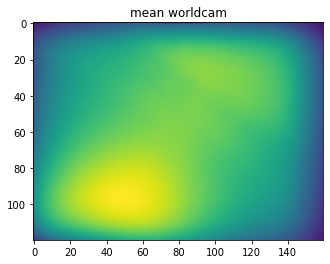

In [52]:
display('shifting worldcam')
xcorrection = xmap.copy()
ycorrection = ymap.copy()

#xcorrection = [0,0]; ycorrection= [0,0]

display('applying gamma to camera')
cam_gamma = 1
world_norm = (world_vid/255)#**cam_gamma

thInterp =interp1d(eyeT,th, bounds_error = False)
phiInterp =interp1d(eyeT,phi, bounds_error = False)

display('shifting worldcam for eyes')
thWorld = thInterp(worldT)
phiWorld = phiInterp(worldT)
for f in tqdm(range(np.shape(world_vid)[0])):
    world_norm[f,:,:] = imshift(world_norm[f,:,:],(-np.int8(thInterp(worldT[f])*ycorrection[0] + phiInterp(worldT[f])*ycorrection[1]),-np.int8(thInterp(worldT[f])*xcorrection[0] + phiInterp(worldT[f])*xcorrection[1])))

display('normalizing world cam')
plt.imshow(np.mean(world_norm,axis=0)); plt.title('mean worldcam')
std_im = np.std(world_norm,axis=0)
std_im[std_im<10/255] = 10/255
img_norm = (world_norm-np.mean(world_norm,axis=0))/std_im
img_norm = img_norm * (std_im>10/255)
world_norm = None; # clear it out.

display('setting up worldcam interpolator')
#img_norm[img_norm<-2] = -2
#movInterp = interp1d(worldT,img_norm,axis=0, kind = 'nearest')

In [53]:
# get timing
print('get timing')
model_dt = 0.025;
model_t = np.arange(0,np.max(worldT),model_dt)
model_nsp = np.zeros((n_units,len(model_t)))

# get spikes / rate
print('get spikes')
bins = np.append(model_t,model_t[-1]+model_dt)
for i,ind in enumerate(goodcells.index):
    model_nsp[i,:],bins = np.histogram(ephys_data.at[ind,'spikeT'],bins)

# get video
print('creating interpolator')
interp = interp1d(worldT,img_norm,'nearest',axis = 0,bounds_error = False)
downsamp = 0.5

print('downsampling')
testimg = img_norm[0,:,:]
testimg = cv2.resize(testimg,(int(np.shape(testimg)[1]*downsamp), int(np.shape(testimg)[0]*downsamp)))
testimg = testimg[10:-10,10:-10]; #remove area affected by eye movement correction
model_vid_sm = np.zeros((len(model_t),np.int(np.shape(testimg)[0]*np.shape(testimg)[1])))


for i in tqdm(range(len(model_t))):
    model_vid = interp(model_t[i] + model_dt/2)
    smallvid = cv2.resize(model_vid,(np.int(np.shape(img_norm)[2]*downsamp),np.int(np.shape(img_norm)[1]*downsamp)),interpolation = cv2.INTER_AREA)
    smallvid = smallvid[10:-10,10:-10];
    model_vid_sm[i,:] = np.reshape(smallvid,np.shape(smallvid)[0]*np.shape(smallvid)[1])
    
#get eye position
print('get eye')
model_th = thInterp(model_t+model_dt/2)
model_phi = phiInterp(model_t+model_dt/2)
model_r = rInterp(model_t+model_dt/2)
dthInterp = interp1d(eyeT[:-1],np.diff(th),'nearest')
model_dth = dthInterp(model_t)


# get gyro z
if free_move:
    print('get gyro')
    interp = interp1d(accT,(gz-np.mean(gz))*7.5,bounds_error=False)
    model_gz = interp(model_t)
    model_active = np.convolve(np.abs(model_gz),np.ones(np.int(1/model_dt)),'same')
    
    # sum and difference of head/eye movements
    model_dgz = model_gz + model_dth;    
    model_dcomp = model_gz -model_dth;
    


get timing
get spikes
creating interpolator


  1%|▍                                                                        | 1020/167699 [00:00<00:16, 10126.09it/s]

downsampling


100%|████████████████████████████████████████████████████████████████████████| 167699/167699 [00:19<00:00, 8728.14it/s]


get eye
get gyro


In [54]:
np.shape(smallvid)

(40, 60)

In [ ]:
# set up eye design matrix
dthInterp = interp1d(eyeT[:-1],np.diff(th),'nearest')
model_dth = dthInterp(model_t)
if free_move:
    interval = 1;
    nt = 20;
    ngroup = 4;
    eyeDesign = np.zeros((len(model_t),ngroup*(interval*nt)));
    gz1 = (model_dth + model_gz);  gz1[gz1<0]=0; gz1 = gz1-np.nanmean(gz1)
    gz2 = -(model_dth + model_gz);  gz2[gz2<0]=0; gz2 = gz2-np.nanmean(gz2)
    gz3 = ( model_gz - model_dth); gz3[gz3<0]=0; gz3 = gz3-np.nanmean(gz3)
    gz4 = -(model_gz - model_dth); gz4[gz4<0]=0; gz4 = gz4-np.nanmean(gz4)

    for t in range(interval*nt,len(model_th)- interval*nt):  # use np.roll instead, with roll = -range : interval, range
        # diff of head/eye
        rng = range(np.int(t-nt/2),np.int(t+nt/2)) ;
        eyeDesign[t,:nt] = gz1[range(np.int(t-nt/2),np.int(t+nt/2))];
        eyeDesign[t,nt:2*(nt)] =  gz2[range(np.int(t-nt/2),np.int(t+nt/2))]
        eyeDesign[t,2*nt:3*(nt)] =  gz3[range(np.int(t-nt/2),np.int(t+nt/2))]
        eyeDesign[t,3*nt:4*(nt)] =  gz4[range(np.int(t-nt/2),np.int(t+nt/2))]
        
else:
    interval = 1;
    nt = 20;
    ngroup = 1;
    eyeDesign = np.zeros((len(model_t),ngroup*(interval*nt+1)));
    model_dth = np.diff(model_th)
    for t in range(interval*nt,len(model_th)- interval*nt):  # use np.roll instead, with roll = -range : interval, range
        eyeDesign[t,:nt+1] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] #- model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))] 

plt.imshow(eyeDesign[1:200,:],aspect = 'auto'); plt.colorbar()
eyeDesign[np.isnan(eyeDesign)] = 0
trange = np.array(range(np.int(-nt/2),np.int(nt/2+1)))

eyePos = eyeDesign.copy();   #eyePos[eyePos<0]=0; #eyePos = (eyePos>3);
eyePos = eyePos - np.mean(eyePos)
eyePos = np.append(eyePos,np.ones((len(model_t),1)), axis = 1) # append column of ones

In [ ]:
plt.imshow(eyeDesign.T@eyeDesign)

In [ ]:
# do simple ridge regression for each unit
for unit in range(n_units): 
    sta_ridge = np.linalg.solve(eyePos.T@eyePos, eyePos.T@model_nsp[unit,:])
    plt.figure(figsize = (16,4))
    plt.subplot(1,3,1)
    plt.plot(sta_ridge[:-1]*100)
    sta= eyePos.T@model_nsp[unit,:]/np.sum(model_nsp[unit,:])  
    plt.plot(sta[:-1],'.')
    plt.title('unit ' + str(unit))
    plt.subplot(1,3,2)
   # plt.plot(model_t,eyePos@sta_ridge); plt.plot(model_t,model_nsp[unit,:]);plt.xlim([1000,1010]);
   # plt.title(str(np.var(model_nsp[unit,:])))

    sp_smooth = (np.convolve(model_nsp[unit,:],np.ones(60),'same'))
    pred_smooth = (np.convolve(eyePos@sta_ridge,np.ones(60),'same'))
    err = np.mean((sp_smooth-pred_smooth)**2)
    plt.title('var = '+ str(np.var(sp_smooth))  + 'err = ' + str(err))


    plt.plot(sp_smooth)
    plt.plot(pred_smooth)
    plt.xlim(0,3600)

    plt.subplot(1,3,3)
    binned_rate, bins,junk = stats.binned_statistic(eyePos@sta_ridge,model_nsp[unit,:],'mean',10)
    plt.plot(bins[:-1],binned_rate); plt.title(str(np.mean((eyePos@sta_ridge - model_nsp[unit,:])**2)))

In [ ]:
# now set up fit
# add additional parameters
nT = np.shape(model_nsp)[1]
if free_move:
    nparams = 80;
    params = eyePos[:,:-1]
else:
    nparams = 1;
    params = np.zeros((nT,nparams))
    params[:,0] = model_r.copy();
np.shape(params)
nparams = 0;

In [ ]:
plt.hist(model_active,30)

In [ ]:
plt.hist(model_th,20)
print(sum(np.abs(model_th)<10))

In [ ]:
nks  = np.shape(smallvid); nk = nks[0]*nks[1];

nspls = [10, 14];
nspl = nspls[0]*nspls[1]
spl = build_spline_matrix(nks, nspls,'cr')
nspline = np.shape(spl)[1]
model_vid_spline = model_vid_sm @ spl
np.shape(model_vid_spline)
model_vid_respline = spl@model_vid_spline[100,:]
plt.subplot(1,2,1)
plt.imshow(np.reshape(model_vid_sm[100,:],nks))
plt.subplot(1,2,2)
plt.imshow(np.reshape(model_vid_respline,nks))

In [ ]:
# set up design matrix with video + params
if free_move:
    use = np.where((np.abs(model_th)<10) & (np.abs(model_phi)<10)& (model_active>25) )[0]
else:
    use = np.where((np.abs(model_th)<50) & (np.abs(model_phi)<50))[0]

nT = np.shape(model_nsp)[1]

#x = model_vid_spline.copy()
x = model_vid_sm.copy();

#subtract mean and renormalize - necessary? 
mn_img = np.mean(x[use,:],axis=0)
x = x-mn_img
x = x/np.std(x[use,:],axis =0)

#add on params
if nparams>0:
    x = np.append(x,params,axis = 1)
x = np.append(x,np.ones((nT,1)), axis = 1) # append column of ones
x = x[use,:]
nks  = np.shape(smallvid); nk = nks[0]*nks[1];
nks



In [ ]:
np.shape(x)

In [ ]:
plt.imshow(np.reshape(model_vid_sm[60*79,:],nks),cmap = 'gray')
np.shape(x)

In [ ]:
# functions for poisson fit
def L1costFun(prs,XX,YY,beta):
    cost = np.mean((XX@prs - YY)**2) + beta * np.sum(np.abs(prs[:-1]))
    return (cost)

In [ ]:
sta = np.linalg.solve(XXtr, XYtr)
L1_sta = op.minimize(fun = L1costFun, method = 'BFGS', x0=sta, args = (x_train, sps_train, 0.01), options={'maxiter':50,'disp': True})
w = L1_sta.x;
np.shape(w)


In [ ]:
crange = np.max(np.abs(spl@w[:-1]))
plt.imshow(np.reshape(spl@w[:-1],nks), vmin = -crange, vmax = crange, cmap = 'jet')
plt.colorbar()

In [ ]:
# functions for poisson fit
def costFun(prs,XX,YY,Cinv,dt):
    vv = XX@prs; #filter output
    rr = np.exp(vv)*dt; # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T@YY; # spike term from Poisson log-likelihood
    Trm0 = sum(rr);  # non-spike term 
    neglogli = Trm1 + Trm0  + .5*prs.T@Cinv@prs;   
    
    dL1 = -XX.T@YY; # spiking term (the spike-triggered average)
    dL0 = XX.T@rr; # non-spiking term
    dL = dL1+dL0;   
    
    g = dL + Cinv@prs
    return (neglogli,g)

def hessfun(prs,XX,YY,Cinv,dt):
    vv = XX@prs; #filter output
    rr = np.exp(vv)*dt; # conditional intensity (per bin)  
    H = XX.T@(XX.T*rr).T + Cinv; 
    return H


In [ ]:
# set up prior matrices (ridge and smoothness)
consecutive = np.ones((nk,1))
consecutive[nks[1]-1::nks[1]] = 0;
diff = np.zeros((1,2)); diff[0,0] = -1; diff[0,1]= 1;
Dxx = sparse.diags((consecutive @ diff).T, np.array([0, 1]), (nk-1,nk))
Dxy = sparse.diags((np.ones((nk,1))@ diff).T, np.array([0, nks[1]]), (nk - nks[1], nk))

Dx = Dxx.T @ Dxx + Dxy.T @ Dxy
Dx

if nparams>0:
    Dx1 = sparse.diags((np.ones((nparams,1))@diff).T,np.array([0,1]),(nparams-1,nparams));
    Dx_params = Dx1.T@Dx1
    np.shape(Dx_params)
                   

In [ ]:
#spline fit version
# now do fit!
glm_method = 'gaussian'
staPdf = PdfPages(name_base+'sta_fm_gaussian_ridgesmooth_rf_ridgeparams_no_mvment_lags.pdf')
lag_list = [0]
for celln in tqdm(range(n_units)):
    for lag_ind, lag in enumerate(lag_list):
        sps = np.roll(model_nsp[celln,:],-lag)
        sps = sps[use];
        nT = len(sps)
        test_frac = 0.3;
        ntest = int(nT*test_frac)
        x_train = x[ntest:,:]
        sps_train = sps[ntest:]
        x_test = x[:ntest,:]
        sps_test = sps[:ntest]

        sta = x_train.T@sps_train/np.sum(sps_train)
        crange = np.max(np.abs(sta[:-1]))
        #plt.imshow(np.reshape(sta[:-1],nks),vmin = -crange, vmax = crange); plt.title('sta')

        XXtr = x_train.T @ x_train;
        XYtr = x_train.T @sps_train;

        #Imat = np.eye(nk);
        Imat = np.eye(nspl)
        Imat = linalg.block_diag(Imat,np.zeros((nparams+1,nparams+1)))
        
        #Imat_params = linalg.block_diag(np.zeros((nk,nk)), Dx_params.toarray(),0)
        Imat_params = linalg.block_diag(np.zeros((nk,nk)), np.eye(nparams),0)
        
        D  = linalg.block_diag(Dx.toarray(),np.zeros((nparams+1,nparams+1)))
        lambdas = 1024 * (2**np.arange(0,16))
        nlam = len(lambdas)

        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        w_ridge = np.zeros((nspl+nparams+1,nlam))
        w = sta; # initial guess
        plt.figure(figsize = (8,8))
        
        print('regularizing spatial')
        for l in range(len(lambdas)):
            if glm_method == 'gaussian':
                w = np.linalg.solve(XXtr + lambdas[l]* Imat, XYtr)  # equivalent of \ (left divide) in matlab

                #w = np.linalg.solve(XXtr + lambdas[l]*(D+ Imat), XYtr)  # equivalent of \ (left divide) in matlab
                #w = np.linalg.solve((XXtr + lambdas[l]*(D)), XYtr)  # equivalent of \ (left divide) in matlab
                #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
                msetrain[l] = np.mean((sps_train - x_train@w)**2)
                msetest[l] = np.mean((sps_test - x_test@w)**2)
                
            elif glm_method == 'L1':
                L1_sta = op.minimize(fun = L1costFun, method = 'dogleg', x0=w, args = (x_train, sps_train, lambdas[l]), jac = True, hess=hessfun,options={'disp': False})
                w = L1_sta.x;
                msetrain[l] = np.mean((sps_train - np.exp(x_train@w))**2)
                msetest[l] = np.mean((sps_test - np.exp(x_test@w))**2)
            
            w_ridge[:,l] =w;

            plt.subplot(4,4,l+1)
            crange = np.max(np.abs(spl@w_ridge[:-(nparams+1),l]))
            plt.imshow(np.reshape(spl@w_ridge[:-(nparams+1),l],nks),vmin = -crange,vmax = crange); plt.colorbar()

        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        w = w_ridge[:,best_lambda]
        ridge_rf = w_ridge[:,best_lambda]
        
        plt.figure(figsize = (4,4))
        plt.subplot(2,2,1)
        plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
        plt.subplot(2,2,3)
        plt.subplot(2,2,3)
        plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

        #plot sta (for comparison)
        plt.subplot(2,2,2)
        crange = np.max(np.abs(spl@sta[:-(nparams+1)]))
        plt.imshow(np.reshape(spl@sta[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('STA')
        
        plt.subplot(2,2,4)
        crange = np.max(np.abs(spl@w[:-(nparams+1)]))
        plt.imshow(np.reshape(spl@w[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('GLM fit')       

        plt.tight_layout()

        if nparams<=1:
            staPdf.savefig()
        
        
        print('regularizing params')
        if nparams>1:
            plt.figure()
            for l in range(len(lambdas)):
                
                if glm_method == 'gaussian':
                    #w = np.linalg.solve((XXtr + lambdas[l]*Imat), XYtr)  # equivalent of \ (left divide) in matlab
                    w = np.linalg.solve((XXtr + lambdas[best_lambda]*(D + Imat) + lambdas[l]*Imat_params), XYtr)  # equivalent of \ (left divide) in matlab
                    #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
                    msetrain[l] = np.mean((sps_train - x_train@w)**2)
                    msetest[l] = np.mean((sps_test - x_test@w)**2)
                
                elif glm_method == 'poisson':
                    poiss_sta = op.minimize(fun = costFun, method = 'dogleg', x0=w, args = (x_train, sps_train, lambdas[best_lambda]*(D+Imat) + lambdas[l]*Imat_params,1 ), jac = True, hess=hessfun,options={'disp': False})
                    w = poiss_sta.x;
                    msetrain[l] = np.mean((sps_train - np.exp(x_train@w))**2)
                    msetest[l] = np.mean((sps_test - np.exp(x_test@w))**2)

                w_ridge[:,l] = w;

                plt.subplot(4,4,l+1)
                plt.plot(w[-nparams:-1])

            best_lambda = np.argmin(msetest)
            ridge_rf = w_ridge[:,best_lambda]

            #staPdf.savefig()

            plt.figure(figsize = (4,4))
            plt.subplot(2,2,1)
            plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
            plt.subplot(2,2,3)
            plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

            #plot sta (for comparison)
            plt.subplot(2,2,2)
            ngroups = 4;
            npts = 20;
            param_fit = ridge_rf[-(nparams+1):-1]
            for i in range(ngroups):
                plt.plot(trange[:-1]*model_dt,param_fit[i*npts :(i+1)*npts], label = str(i))
            plt.title('parameter fits'); plt.xlabel('secs')
            plt.xlim([-0.25,0.25]); #plt.legend()

            plt.subplot(2,2,4)
            crange = np.max(np.abs(ridge_rf[:-(nparams+1)]))
            plt.imshow(np.reshape(ridge_rf[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
            plt.title('GLM fit')       

            plt.tight_layout()

            staPdf.savefig()

        plt.figure()
        
        sta = np.linalg.solve(XXtr, XYtr)
        L1_sta = op.minimize(fun = L1costFun, method = 'BFGS', x0=sta, args = (x_train, sps_train, 0.005), options={'maxiter':50,'disp': True})
        ridge_rf = L1_sta.x;
        
        crange = np.max(np.abs(spl@ridge_rf[:-1]))
        plt.imshow(np.reshape(spl@ridge_rf[:-1],nks), vmin = -crange, vmax = crange, cmap = 'jet')
        plt.colorbar()
        staPdf.savefig()

        if glm_method == 'gaussian':
            sp_pred = x_test@ridge_rf
        elif glm_method=='poisson':
            sp_pred = np.exp(x_test@ridge_rf)
        
        plt.figure()
        bin_length = 80;
        sp_smooth = (np.convolve(sps_test,np.ones(bin_length),'same'))/(bin_length*model_dt)
        pred_smooth = (np.convolve(sp_pred,np.ones(bin_length),'same'))/(bin_length*model_dt)
        err = np.mean((sp_smooth-pred_smooth)**2)
        print('var = '+ str(np.var(sp_smooth)))
        print('err = ' + str(err))

        maxt = 3600;
        plt.plot(model_t[0:maxt],sp_smooth[0:maxt],label = 'actual')
        plt.plot(model_t[0:maxt],pred_smooth[0:maxt],label='predicted')
        plt.xlabel('secs'); plt.ylabel('sp/sec'); plt.legend(); plt.xlim([0,90])
        cc = np.corrcoef(sp_smooth, pred_smooth)
        #plt.title('correlation = ' + str(cc[0,1]))
        expvar =(np.var(sp_smooth) - err)/(np.var(sp_smooth) )
        plt.title('exp var = '+str(expvar) + 'correlation = ' + str(cc[0,1]))

        c = np.std(x_test,axis=1)
        #plt.plot(model_t[0:maxt],c[0:maxt])
                                    
        staPdf.savefig()

    #plt.figure()
    #plt.hist(x_test@ridge_rf)
staPdf.close()

In [ ]:
pwd

In [ ]:
# spatial plus params
# now do fit!
glm_method = 'gaussian'
staPdf = PdfPages(name_base+'sta_fm_gaussian_ridgesmooth_rf_ridgeparams_no_mvment_lags.pdf')
lag_list = [0]
for celln in tqdm(range(1)):
    for lag_ind, lag in enumerate(lag_list):
        sps = np.roll(model_nsp[celln,:],-lag)
        sps = sps[use];
        nT = len(sps)
        test_frac = 0.3;
        ntest = int(nT*test_frac)
        x_train = x[ntest:,:]
        sps_train = sps[ntest:]
        x_test = x[:ntest,:]
        sps_test = sps[:ntest]

        sta = x_train.T@sps_train/np.sum(sps_train)
        crange = np.max(np.abs(sta[:-1]))
        #plt.imshow(np.reshape(sta[:-1],nks),vmin = -crange, vmax = crange); plt.title('sta')

        XXtr = x_train.T @ x_train;
        XYtr = x_train.T @sps_train;

        Imat = np.eye(nk);

        Imat = linalg.block_diag(Imat,np.zeros((nparams+1,nparams+1)))
        
        #Imat_params = linalg.block_diag(np.zeros((nk,nk)), Dx_params.toarray(),0)
        Imat_params = linalg.block_diag(np.zeros((nk,nk)), np.eye(nparams),0)
        
        D  = linalg.block_diag(Dx.toarray(),np.zeros((nparams+1,nparams+1)))
        lambdas = 1024 * (2**np.arange(0,16))
        nlam = len(lambdas)

        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        w_ridge = np.zeros((nk+nparams+1,nlam))
        w = sta; # initial guess
        plt.figure(figsize = (8,8))
        
        print('regularizing spatial')
        for l in range(len(lambdas)):
            if glm_method == 'gaussian':
               # w = np.linalg.solve(XXtr + lambdas[l]* Imat, XYtr)  # equivalent of \ (left divide) in matlab

                w = np.linalg.solve(XXtr + lambdas[l]*(D+ Imat), XYtr)  # equivalent of \ (left divide) in matlab
                #w = np.linalg.solve((XXtr + lambdas[l]*(D)), XYtr)  # equivalent of \ (left divide) in matlab
                #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
                msetrain[l] = np.mean((sps_train - x_train@w)**2)
                msetest[l] = np.mean((sps_test - x_test@w)**2)
                
            elif glm_method == 'poisson':
                poiss_sta = op.minimize(fun = costFun, method = 'dogleg', x0=w, args = (x_train, sps_train, lambdas[l]*(D+Imat) ,1 ), jac = True, hess=hessfun,options={'disp': False})
                w = poiss_sta.x;
                msetrain[l] = np.mean((sps_train - np.exp(x_train@w))**2)
                msetest[l] = np.mean((sps_test - np.exp(x_test@w))**2)
            
            w_ridge[:,l] =w;

            plt.subplot(4,4,l+1)
            crange = np.max(np.abs(w_ridge[:-(nparams+1),l]))
            plt.imshow(np.reshape(w_ridge[:-(nparams+1),l],nks),vmin = -crange,vmax = crange,cmap = 'jet'); #plt.colorbar()

        staPdf.savefig()
        
        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        w = w_ridge[:,best_lambda]
        ridge_rf = w_ridge[:,best_lambda]
        
        plt.figure(figsize = (4,4))
        plt.subplot(2,2,1)
        plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
        plt.subplot(2,2,3)
        plt.subplot(2,2,3)
        plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

        #plot sta (for comparison)
        plt.subplot(2,2,2)
        crange = np.max(np.abs(sta[:-(nparams+1)]))
        plt.imshow(np.reshape(sta[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('STA')
        
        plt.subplot(2,2,4)
        crange = np.max(np.abs(w[:-(nparams+1)]))
        plt.imshow(np.reshape(w[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('GLM fit')       

        plt.tight_layout()

        if nparams<=1:
            staPdf.savefig()
        
        
        print('regularizing params')
        if nparams>1:
            plt.figure()
            for l in range(len(lambdas)):
                
                if glm_method == 'gaussian':
                    #w = np.linalg.solve((XXtr + lambdas[l]*Imat), XYtr)  # equivalent of \ (left divide) in matlab
                    w = np.linalg.solve((XXtr + lambdas[best_lambda]*(D + Imat) + lambdas[l]*Imat_params), XYtr)  # equivalent of \ (left divide) in matlab
                    #w = np.linalg.solve((XXtr + lambdas[l]*(D + Imat)), XYtr)  # equivalent of \ (left divide) in matlab
                    msetrain[l] = np.mean((sps_train - x_train@w)**2)
                    msetest[l] = np.mean((sps_test - x_test@w)**2)
                
                elif glm_method == 'poisson':
                    poiss_sta = op.minimize(fun = costFun, method = 'dogleg', x0=w, args = (x_train, sps_train, lambdas[best_lambda]*(D+Imat) + lambdas[l]*Imat_params,1 ), jac = True, hess=hessfun,options={'disp': False})
                    w = poiss_sta.x;
                    msetrain[l] = np.mean((sps_train - np.exp(x_train@w))**2)
                    msetest[l] = np.mean((sps_test - np.exp(x_test@w))**2)

                w_ridge[:,l] = w;

                plt.subplot(4,4,l+1)
                plt.plot(w[-nparams:-1])

            best_lambda = np.argmin(msetest)
            ridge_rf = w_ridge[:,best_lambda]

            #staPdf.savefig()

            plt.figure(figsize = (4,4))
            plt.subplot(2,2,1)
            plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
            plt.subplot(2,2,3)
            plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

            #plot sta (for comparison)
            plt.subplot(2,2,2)
            ngroups = 4;
            npts = 20;
            param_fit = ridge_rf[-(nparams+1):-1]
            for i in range(ngroups):
                plt.plot(trange[:-1]*model_dt,param_fit[i*npts :(i+1)*npts], label = str(i))
            plt.title('parameter fits'); plt.xlabel('secs')
            plt.xlim([-0.25,0.25]); #plt.legend()

            plt.subplot(2,2,4)
            crange = np.max(np.abs(ridge_rf[:-(nparams+1)]))
            plt.imshow(np.reshape(ridge_rf[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
            plt.title('GLM fit')       

            plt.tight_layout()

            staPdf.savefig()

        plt.figure()
                                    
        if glm_method == 'gaussian':
            sp_pred = x_test@ridge_rf
        elif glm_method=='poisson':
            sp_pred = np.exp(x_test@ridge_rf)
        
        bin_length = 80;
        sp_smooth = (np.convolve(sps_test,np.ones(bin_length),'same'))/(bin_length*model_dt)
        pred_smooth = (np.convolve(sp_pred,np.ones(bin_length),'same'))/(bin_length*model_dt)
        err = np.mean((sp_smooth-pred_smooth)**2)
        print('var = '+ str(np.var(sp_smooth)))
        print('err = ' + str(err))

        maxt = 3600;
        plt.plot(model_t[0:maxt],sp_smooth[0:maxt],label = 'actual')
        plt.plot(model_t[0:maxt],pred_smooth[0:maxt],label='predicted')
        plt.xlabel('secs'); plt.ylabel('sp/sec'); plt.legend(); plt.xlim([0,90])
        cc = np.corrcoef(sp_smooth, pred_smooth)
        #plt.title('correlation = ' + str(cc[0,1]))
        expvar =(np.var(sp_smooth) - err)/(np.var(sp_smooth) )
        plt.title('exp var = '+str(expvar) + 'correlation = ' + str(cc[0,1]))

        c = np.std(x_test,axis=1)
        #plt.plot(model_t[0:maxt],c[0:maxt])
                                    
        staPdf.savefig()

    #plt.figure()
    #plt.hist(x_test@ridge_rf)
staPdf.close()

In [ ]:
# spatial only - simple
# now do fit!
glm_method = 'gaussian'
staPdf = PdfPages(name_base+'sta_fm_gaussian_ridgesmooth_rf_ridgeparams_no_mvment_lags.pdf')
lag_list = [0]
for celln in tqdm(range(1)):
    for lag_ind, lag in enumerate(lag_list):
        
        # spikes = sps[time]
        # stim = x[time,features]
        
        sps = np.roll(model_nsp[celln,:],-lag)
        sps = sps[use];
        nT = len(sps)
        
        #split training and test data
        test_frac = 0.3;
        ntest = int(nT*test_frac)
        x_train = x[ntest:,:]
        sps_train = sps[ntest:]
        x_test = x[:ntest,:]
        sps_test = sps[:ntest]

        #calculate a few terms
        sta = x_train.T@sps_train/np.sum(sps_train)
        XXtr = x_train.T @ x_train;
        XYtr = x_train.T @sps_train;

        #L2 prior
        Imat = np.eye(nk);
        Imat = linalg.block_diag(Imat,np.zeros((1,1)))
        
        #smoothness prior
        D  = linalg.block_diag(Dx.toarray(),np.zeros((1,1)))      
        
        #summed prior matrix
        Cinv = D + Imat;
        
        lambdas = 1024 * (2**np.arange(0,16))
        nlam = len(lambdas)

        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        w_ridge = np.zeros((nk+nparams+1,nlam))
        w = sta; # initial guess
        
        plt.figure(figsize = (8,8))
        
        print('regularizing spatial')
        for l in range(len(lambdas)):  # loop over regularization strength

            # calculate MAP estimate               
            w = np.linalg.solve(XXtr + lambdas[l]*Cinv, XYtr)  # equivalent of \ (left divide) in matlab
            w_ridge[:,l] =w;
            
            #calculate test and training rms error
            msetrain[l] = np.mean((sps_train - x_train@w)**2)
            msetest[l] = np.mean((sps_test - x_test@w)**2)
                
            #plot MAP estimate for this lambda
            plt.subplot(4,4,l+1)
            crange = np.max(np.abs(w_ridge[:-(nparams+1),l]))
            plt.imshow(np.reshape(w_ridge[:-(nparams+1),l],nks),vmin = -crange,vmax = crange,cmap = 'jet'); #plt.colorbar()

        staPdf.savefig()
        
        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        w = w_ridge[:,best_lambda]
        ridge_rf = w_ridge[:,best_lambda]
        
        
        #plotting!!!
        
        # training/test errors
        plt.figure(figsize = (4,4))
        plt.subplot(2,2,1)
        plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
        plt.subplot(2,2,3)
        plt.subplot(2,2,3)
        plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

        #plot sta (for comparison)
        plt.subplot(2,2,2)
        crange = np.max(np.abs(sta[:-(nparams+1)]))
        plt.imshow(np.reshape(sta[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('STA')
        
        #best cross-validated RF
        plt.subplot(2,2,4)
        crange = np.max(np.abs(w[:-(nparams+1)]))
        plt.imshow(np.reshape(w[:-(nparams+1)],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('GLM fit')       

        plt.tight_layout()
        staPdf.savefig()
        
        # plot predicted vs actual firing rate
        
        plt.figure()
        # predicted firing rate
        sp_pred = x_test@ridge_rf
        
        # bin the firing rate to get smooth rate vs time
        bin_length = 80;
        sp_smooth = (np.convolve(sps_test,np.ones(bin_length),'same'))/(bin_length*model_dt)
        pred_smooth = (np.convolve(sp_pred,np.ones(bin_length),'same'))/(bin_length*model_dt)

        #plot
        maxt = 3600;
        plt.plot(model_t[0:maxt],sp_smooth[0:maxt],label = 'actual')
        plt.plot(model_t[0:maxt],pred_smooth[0:maxt],label='predicted')
        plt.xlabel('secs'); plt.ylabel('sp/sec'); plt.legend(); plt.xlim([0,90])
        
        # a couple diagnoistics for the title
        err = np.mean((sp_smooth-pred_smooth)**2)
        cc = np.corrcoef(sp_smooth, pred_smooth)
        expvar =(np.var(sp_smooth) - err)/(np.var(sp_smooth) )
        plt.title('exp var = '+str(expvar) + 'correlation = ' + str(cc[0,1]))                                  
        
        staPdf.savefig()

staPdf.close()

In [ ]:
staPdf = PdfPages(name_base+'sta_fm_gaussian_ridgesmooth_rf_ridgeparams_no_mvment_lags.pdf')
lag_list = [0]
for celln in tqdm(range(1)):
    for lag_ind, lag in enumerate(lag_list):
        
        # spikes = sps[time]
        # stim = x[time,features]
        
        sps = np.roll(model_nsp[celln,:],-lag)
        sps = sps[use];
        nT = len(sps)
        
        #split training and test data
        test_frac = 0.3;
        ntest = int(nT*test_frac)
        x_train = x[ntest:,:]
        sps_train = sps[ntest:]
        x_test = x[:ntest,:]
        sps_test = sps[:ntest]

        #calculate a few terms
        sta = x_train.T@sps_train/np.sum(sps_train)
        XXtr = x_train.T @ x_train;
        XYtr = x_train.T @sps_train;

        #L2 prior
        Imat = np.eye(nk);
        Imat = linalg.block_diag(Imat,np.zeros((1,1)))
        
        #smoothness prior
        D  = linalg.block_diag(Dx.toarray(),np.zeros((1,1)))      
        
        #summed prior matrix
        Cinv = D + Imat;
        
        lambdas = 1024 * (2**np.arange(0,16))
        nlam = len(lambdas)

        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        w_ridge = np.zeros((nk+nparams+1,nlam))
        w = sta; # initial guess
        
        plt.figure(figsize = (8,8))
        
        print('regularizing spatial')
        for l in range(len(lambdas)):  # loop over regularization strength

            # calculate MAP estimate               
            w = np.linalg.solve(XXtr + lambdas[l]*Cinv, XYtr)  # equivalent of \ (left divide) in matlab
            w_ridge[:,l] =w;
            
            #calculate test and training rms error
            msetrain[l] = np.mean((sps_train - x_train@w)**2)
            msetest[l] = np.mean((sps_test - x_test@w)**2)
                
            #plot MAP estimate for this lambda
            plt.subplot(4,4,l+1)
            crange = np.max(np.abs(w_ridge[:-1,l])) #calculate color range for imshow; leave out last value which is spike rate offset
            plt.imshow(np.reshape(w_ridge[:-1,l],nks),vmin = -crange,vmax = crange,cmap = 'jet'); #plt.colorbar()

        staPdf.savefig()
        
        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        w = w_ridge[:,best_lambda]
        ridge_rf = w_ridge[:,best_lambda]
        
        
        #plotting!!!
        
        # training/test errors
        plt.figure(figsize = (4,4))
        plt.subplot(2,2,1)
        plt.plot(msetrain);  plt.xlabel('lambda'); plt.ylabel('training mse'); plt.title('unit' + str(celln) + ' lag'+str(lag))
        plt.subplot(2,2,3)
        plt.subplot(2,2,3)
        plt.plot(msetest); plt.xlabel('lambda'); plt.ylabel('testing mse'); plt.title('var=' + str(np.var(sps_test)))

        #plot sta (for comparison)
        plt.subplot(2,2,2)
        crange = np.max(np.abs(sta[:-1]))
        plt.imshow(np.reshape(sta[:-1],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('STA')
        
        #best cross-validated RF
        plt.subplot(2,2,4)
        crange = np.max(np.abs(w[:-1]))
        plt.imshow(np.reshape(w[:-1],nks),vmin = -crange, vmax= crange, cmap = 'jet')
        plt.title('GLM fit')       

        plt.tight_layout()
        staPdf.savefig()


In [ ]:
# custom movie for UCSB talk

makeMovie = False
if makeMovie:
    this_unit = 0;

    #eyeInterp = interp1d(eyeT,eye_vid,axis=0)
    #worldInterp = interp1d(worldT,world_vid,axis=0)


    fig = plt.figure(figsize = (8,12))
    gs = fig.add_gridspec(7,4)
    axEye = fig.add_subplot(gs[0:2,0:2])
    axWorld = fig.add_subplot(gs[0:2,2:4])

    axRad = fig.add_subplot(gs[2,:])
    axTheta = fig.add_subplot(gs[3,:])
    #axdTheta = fig.add_subplot(gs[4,:])
    axGyro = fig.add_subplot(gs[4,:])
    #axContrast = fig.add_subplot(gs[6,:])
    axR = fig.add_subplot(gs[5:7,:])
    #axRad = fig.add_subplot(gs[3,:])

    #timerange and center frame (only)
    tr = [30,60]
    fr = np.mean(tr) # time for frame
    eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
    worldFr = np.abs(worldT-fr).argmin(dim = "frame")

    axEye.cla(); axEye.axis('off'); 
    axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
    #axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
    axEye.set_xlim(40,120); axEye.set_ylim(30,90)

    axWorld.cla();  axWorld.axis('off'); 
    axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

    # plot contrast
    #axContrast.plot(worldT,contrast)
    #axContrast.set_xlim(tr[0],tr[1]); axContrast.set_ylim(0,2)
    #axContrast.set_ylabel('image contrast')

    #plot radius
    axRad.cla()
    axRad.plot(eyeT,eye_params.sel(ellipse_params = 'longaxis'))
    axRad.set_xlim(tr[0],tr[1]); 
    axRad.set_ylabel('pupil radius');  axRad.set_ylim(20,60)

    #plot eye position
    axTheta.cla()
    axTheta.plot(eyeT,(eye_params.sel(ellipse_params = 'theta')-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
    axTheta.set_xlim(tr[0],tr[1]); 
    axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-35,35)

    # plot eye velocity
    #axdTheta.cla()
    #axdTheta.plot(eyeT[0:-1],dEye*60); axdTheta.set_ylabel('dtheta')
    #sacc = np.transpose(np.where(np.abs(dEye)>10))
    #axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
    #axdTheta.set_xlim(tr[0],tr[1]); 
    #axdTheta.set_ylim(-900,900); axdTheta.set_ylabel('eye vel - deg/sec')

    # plot gyro

    axGyro.plot(accT,(gz-np.mean(gz))*7.5*60)
    axGyro.set_xlim(tr[0],tr[1]); axGyro.set_ylim([-500,500])
    axGyro.set_ylabel('gyro deg/sec')



    # plot spikes
    axR.fontsize = 20
    for i,ind in enumerate(goodcells.index):
        axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
    axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

    n_units = len(goodcells)

    axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , n_units); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
    axR.spines['right'].set_visible(False)
    axR.spines['top'].set_visible(False)

    plt.tight_layout()

    vidfile = name_base+ '_unit'+str(this_unit)+'.mp4'
    # now animate
    writer = FFMpegWriter(fps=30)
    with writer.saving(fig, vidfile, 100):
        for t in tqdm(np.arange(tr[0],tr[1],1/30)):

            # show eye and world frames
            axEye.cla(); axEye.axis('off'); 
            axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
            axEye.set_xlim(30,150); axEye.set_ylim(105,15)

            axWorld.cla(); axWorld.axis('off'); 
            axWorld.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")

            #plot line for time, then remove
            ln = axR.vlines(t,-0.5,30,'b')
            writer.grab_frame()
            ln.remove()


    # generate wave file
    sp = np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
    sp = sp[sp>0]
    datarate = 30000

    # compute waveform samples
    tmax = tr[1]-tr[0]
    t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
    x = np.zeros(np.size(t))
    for spt in sp[sp<tmax]:
        x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
        x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1

    # Write the samples to a file
    audfile = name_base+'_unit'+str(this_unit)+'.wav'
    wavio.write(audfile, x, datarate, sampwidth=1)

    merge_mp4_name = name_base+'_merge_unit'+str(this_unit)+'.mp4'
    print('merging movie with sound')
    subprocess.call(['ffmpeg', '-i', vidfile, '-i', audfile, '-c:v', 'copy', '-c:a', 'aac', '-y', merge_mp4_name])
    print(merge_mp4_name)

In [ ]:
np.shape(eyeInterp(1))

In [ ]:
sp_smooth = (np.convolve(sps_test,np.ones(40),'same'))
pred_smooth = (np.convolve(sp_pred,np.ones(40),'same'))
err = np.mean((sp_smooth-pred_smooth)**2)
print('var = '+ str(np.var(sp_smooth)))
print('err = ' + str(err))

maxt = 4800;
plt.plot(model_t[0:maxt],sp_smooth[0:maxt],label = 'actual')
plt.plot(model_t[0:maxt],pred_smooth[0:maxt],label='predicted')
plt.xlabel('secs'); plt.ylabel('sp/sec'); plt.legend(); plt.xlim([0,120])
expvar =(np.var(sp_smooth) - err)/(np.var(sp_smooth) - np.mean(sp_smooth))
plt.title('exp var = ' + str(expvar))
c = np.std(x_test,axis=1)
plt.plot(model_t[0:maxt],c[0:maxt])

In [ ]:
plt.plot(pred_smooth[::1],sp_smooth[::1],'.')
binned_sp,bins,junk = stats.binned_statistic(pred_smooth,sp_smooth,'mean',20)
plt.plot(0.5*(bins[:-1]+bins[1:]),binned_sp)
plt.xlabel('predicted'); plt.ylabel('actual')
#plt.plot([0,3],[0,3])
#plt.ylim([0,5])

In [ ]:
paramfit = ridge_rf[-40:-1]
plt.plot((np.arange(len(paramfit))-len(paramfit)/2)*model_dt,paramfit)
plt.xlabel('secs'); plt.title('dEye filter')

In [ ]:
sta = np.zeros((60*80))
sta[goodpts[0]] = glm.beta_
sta = np.reshape(sta,(60,80))
climrange = np.max(np.abs(sta))
plt.imshow(sta,cmap = 'jet', vmin = -climrange, vmax = climrange ); plt.colorbar()

In [ ]:
interval = 1;
nt = 20;
ngroup = 2;
eyeDesign = np.zeros((len(model_t),ngroup*(interval*nt+1)));
model_dth = np.diff(model_th)
for t in range(interval*nt,len(model_th)- interval*nt):  # use np.roll instead, with roll = -range : interval, range
    eyeDesign[t,:nt+1] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] - model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))] 
    eyeDesign[t,nt+1:2*(nt+1)] =  model_dth[range(np.int(t-nt/2),np.int(t+nt/2+1)) ] + model_gz[range(np.int(t-nt/2),np.int(t+nt/2+1))]
plt.imshow(eyeDesign[1:200,:],aspect = 'auto'); plt.colorbar()
eyeDesign[np.isnan(eyeDesign)] = 0
trange = np.array(range(np.int(-nt/2),np.int(nt/2+1)))

In [ ]:
trangeAll = np.append(trange,trange)
for unit in range(n_units): 
    eyePos = eyeDesign.copy();   eyePos[eyePos<0]=0; #eyePos = (eyePos>3);
    eyePos = eyePos - np.mean(eyePos)
    eyePos = np.append(eyePos,np.ones((len(model_t),1)), axis = 1) # append column of ones
    sta_ridge = np.linalg.solve(eyePos.T@eyePos, eyePos.T@model_nsp[unit,:])
    plt.figure(figsize = (16,4))
    plt.subplot(1,3,1)
    plt.plot(-trangeAll*model_dt,sta_ridge[:-1]*100)
    sta= eyePos.T@model_nsp[unit,:]/np.sum(model_nsp[unit,:])  
    plt.plot(-trangeAll*model_dt,sta[:-1],'.')
    plt.title(str(np.mean(model_nsp[unit,:])))
    plt.subplot(1,3,2)
   # plt.plot(model_t,eyePos@sta_ridge); plt.plot(model_t,model_nsp[unit,:]);plt.xlim([1000,1010]);
   # plt.title(str(np.var(model_nsp[unit,:])))
    
    sp_smooth = (np.convolve(model_nsp[unit,:],np.ones(60),'same'))
    pred_smooth = (np.convolve(eyePos@sta_ridge,np.ones(60),'same'))
    err = np.mean((sp_smooth-pred_smooth)**2)
    plt.title('var = '+ str(np.var(sp_smooth))  + 'err = ' + str(err))


    plt.plot(sp_smooth)
    plt.plot(pred_smooth)
    plt.xlim(0,3600)
    
    plt.subplot(1,3,3)
    binned_rate, bins,junk = stats.binned_statistic(eyePos@sta_ridge,model_nsp[unit,:],'mean',10)
    plt.plot(bins[:-1],binned_rate); plt.title(str(np.mean((eyePos@sta_ridge - model_nsp[unit,:])**2)))
    
                                               
    #plt.ylim([-0.6,0.6])

In [ ]:
model_nsp[np.isnan(model_nsp)] = 0
eyeDesign[np.isnan(eyeDesign)] = 0

In [ ]:
c = 4
st_move = ((eyeDesign.T @ model_nsp[c,:]) / np.nansum(model_nsp[c,:])) # - np.mean(eyeDesign,axis=0)
plt.plot(st_move[1:])

In [ ]:
st_move

In [ ]:
c = 8
glm = GLM(distr='softplus', score_metric='pseudo_R2', reg_lambda=0.001, alpha = 0.05, max_iter=5000, verbose = True)

eyeDesign[np.isnan(eyeDesign)]=0
# fit the model on the training data
eyeNeg = eyeDesign.copy();
eyeNeg[eyeNeg>0]=0;
eyePos = eyeDesign.copy();
eyePos[eyeNeg<0]=0;

glm.fit(eyeDesign, model_nsp[c,:])
plt.plot(glm.beta_[1:])

In [ ]:
fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
lag = 0;
for c in tqdm(range(n_units)):
    sp = np.roll(model_nsp[c,:],lag)
    nonzero = np.where(sp>0)[0]
    ensemble = np.moveaxis(model_vid[nonzero,:,:],(0,1,2),(2,0,1)) * sp[nonzero]
    sta = np.nansum(ensemble,axis=2)/np.sum(sp)
    plt.subplot(np.ceil(n_units/4),4,c+1)
    plt.imshow(sta,vmin=-0.3,vmax=0.3,cmap = 'jet')

In [ ]:
junk

In [ ]:
#first, calculate mean STA for frames that meet eye criteria
# then, can subtract this off from each STA

goodcells['ensemble'] = np.nan
goodcells['ensemble'] = goodcells['ensemble'].astype(object)

staAll = np.zeros((n_units,np.shape(img_norm)[1],np.shape(img_norm)[2]))
lag = 0.0
fig = plt.figure(figsize = (12,np.ceil(n_units/2)))
for c, ind in enumerate(goodcells.index):
    sta = 0; nsp = 0
    sp = goodcells.at[ind,'spikeT'].copy()

    ensemble = np.zeros((len(sp),np.shape(img_norm)[1],np.shape(img_norm)[2]))
    for s in tqdm(sp):
        if (s-lag >5) & ((s-lag) <np.max(worldT))  & (thInterp(s-lag)>0) & (np.abs(phiInterp(s-lag))<10):
            nsp = nsp+1
            im = movInterp(s-lag)
            ensemble[nsp-1,:,:] = im;
            sta = sta+im
    #goodcells.at[ind,'ensemble'] = ensemble
    plt.subplot(np.ceil(n_units/4),4,c+1)
    #plt.title(str(nsp))
    plt.title(f'ind={ind!s} nsp={nsp!s}')
    plt.axis('off')
    if nsp > 0:
        sta = sta/nsp - staNull
    else:
        sta = np.nan
    if pd.isna(sta) is True:
        plt.imshow(np.zeros([120,160]))
    else:
        plt.imshow((sta ),vmin=-0.6,vmax=0.6,cmap = 'jet')
        staAll[c,:,:] = sta
plt.tight_layout()

In [ ]:
plt.hist(phi,np.arange(-90,90,5))
np.sum((np.abs(th)<10) &(np.abs(phi)<10) ) /len(th)

In [ ]:
lagRange = np.arange(-0.05,0.2,0.05)
fig = plt.figure(figsize = (12,2*n_units))
for c, ind in enumerate(goodcells.index):
    sp = goodcells.at[ind,'spikeT'].copy()
    for  lagInd, lag in enumerate(lagRange):
        sta = 0; nsp = 0
        for s in tqdm(sp):
            if (s-lag >5) & ((s-lag) <np.max(worldT))  & (np.abs(thInterp(s-lag))<10) & (np.abs(phiInterp(s-lag))<10):
                nsp = nsp+1
                sta = sta+movInterp((s-lag))
        plt.subplot(n_units,6,(c*6)+lagInd + 1)
        if nsp > 0:
            sta = sta/nsp
        else:
            sta = np.nan
        if pd.isna(sta) is True:
            plt.imshow(np.zeros([120,160]))
        else:
            plt.imshow(sta,vmin=-0.4,vmax=0.4,cmap = 'jet')
        # plt.title(str(c) + ' ' + str(np.round(lag*1000)) + 'msec')
        if c == 0:
            plt.title(str(np.round(lag*1000)) + 'msec')
        plt.axis('off')
plt.tight_layout()


In [ ]:
stop here

In [ ]:
# get worldcam correction based on eye-movement vs frameshift regression
if free_move:
    print('getting worldcam correction')
    number_of_iterations = 5000
    termination_eps = 1e-4
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    warp_mode = cv2.MOTION_EUCLIDEAN
    max_frames = 60*60
    cc = np.zeros(max_frames); xshift = np.zeros(max_frames); yshift = np.zeros(max_frames);omegashift = np.zeros(max_frames)
    # get shift between adjacent frames
    for i in tqdm(range(max_frames)):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc[i], warp_matrix) = cv2.findTransformECC (world_vid[i,:,:],world_vid[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift[i] = warp_matrix[0,2]; yshift[i] = warp_matrix[1,2]
        omegashift[i] = np.arctan2(warp_matrix[0,1],warp_matrix[0,0])

In [ ]:
plt.plot(worldT[0:max_frames],np.cumsum(omegashift*180/3.14))
plt.plot(eyeT[0:max_frames], omega[0:max_frames]-8)
plt.xlim([30,40])

In [ ]:
plt.plot(eyeT[0:max_frames],omega[0:max_frames])
plt.xlim([15,20])

In [ ]:
#correct movie
max_frames = 60*60
thInterp =interp1d(eyeT,th, bounds_error = False, fill_value = 0)
phiInterp =interp1d(eyeT,phi, bounds_error = False, fill_value = 0)

world_fix = np.zeros((max_frames, np.size(world_vid,1), np.size(world_vid,2)),'uint8')
for f in tqdm(range(max_frames)):
    t = worldT[f]
    thInt = thInterp(t)
    if np.isnan(thInt):
        thInt =0
    phiInt = phiInterp(t) 
    if np.isnan(phiInt):
        phiInt =0

    world_fix[f,:,:]= imshift(world_vid[f,:,:],(-(thInt*ymap[0] + phiInt*ymap[1]),-(thInt*xmap[0] + phiInt*xmap[1])))



In [ ]:
#compare alignement pre and post correction
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
warp_mode = cv2.MOTION_TRANSLATION
cc_fix = np.zeros(max_frames); xshift_fix = np.zeros(max_frames); yshift_fix = np.zeros(max_frames);
for i in tqdm(range(max_frames-1)):
    try:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        (cc_fix[i], warp_matrix) = cv2.findTransformECC (world_fix[i,:,:],world_fix[i+1,:,:],warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
        xshift_fix[i] = warp_matrix[0,2]; yshift_fix[i] = warp_matrix[1,2]
    except:
        xshift_fix[i] = np.nan; yshift_fix[i] = np.nan # very rarely, a frame will raise cv2 error when iterations do not converge for transform

if free_move:
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(xshift,label = 'x pre alignment')
    plt.plot(xshift_fix,label = 'x post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    plt.subplot(2,1,2)
    plt.plot(yshift,label = 'y pre alignment')
    plt.plot(yshift_fix, label = 'y post alignement')
    plt.ylim(-5,5); plt.xlim(1000,1500)

    diagnostic_pdf.savefig()
    plt.close()



In [ ]:
# get optic flow pre/post correction
max_frame = 60*60
flow = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
flow_fix = np.zeros((max_frame, np.size(world_vid,1), np.size(world_vid,2),2))
x,y = np.meshgrid(np.arange(0, np.size(world_vid,2)), np.arange(0,np.size(world_vid,1)))
vidfile = os.path.join(file_dict['save'], (file_dict['name']+'_flowfix.mp4'))

print('plotting video of optical flow')
fig, axs = plt.subplots(1,2,figsize = (16,8))
# now animate
writer = FFMpegWriter(fps=30)
nx = 5
with writer.saving(fig, vidfile, 100):
    for f in tqdm(range(max_frame-1)):

        flow[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_vid[f,:,:],world_vid[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[0].cla()
        axs[0].imshow(world_vid[f,:,:],vmin = 0, vmax = 255)
        u = flow[f,:,:,0]; v = flow[f,:,:,1]
        axs[0].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        flow_fix[f,:,:,:] = cv2.calcOpticalFlowFarneback(world_fix[f,:,:],world_fix[f+1,:,:], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        axs[1].cla()
        axs[1].imshow(world_fix[f,:,:],vmin = 0, vmax = 255)
        u = flow_fix[f,:,:,0]; v = flow[f,:,:,1]
        axs[1].quiver(x[::nx,::nx],y[::nx,::nx],u[::nx,::nx],-v[::nx,::nx], scale = 100 )

        writer.grab_frame()